In [1]:
import rasa_core
from rasa_core.agent import Agent
from bokeh.io import output_notebook
agent = Agent.load("models/dialogue_embed")
# agent = Agent.load("models/dialogue_embed_before_norm_loss")
output_notebook()

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from models/dialogue_embed/policy_0_EmbeddingPolicy/tensorflow_embedding.ckpt


/anaconda/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


Loading BokehJS ...

In [2]:
policy = agent.policy_ensemble.policies[0]
interpreter = agent.interpreter

In [3]:
domain = agent.domain


In [4]:
from rasa_core.training.structures import StoryGraph
from rasa_core.training.dsl import StoryFileReader
from rasa_core.trackers import DialogueStateTracker
from rasa_core.channels import UserMessage
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def embedding_from_tracker(story, bot=False):
    reader = StoryFileReader(domain, interpreter)
    story = story.split('\n')
    story_steps = reader.process_lines(story)
#     story_graph = StoryGraph(story_steps)
    tracker = DialogueStateTracker(
            1,
            domain.slots
    )
    tracker._reset()
    for step in story_steps:
        events = step.explicit_events(domain)
        for event in events:
            tracker.update(event)
    data_X = policy.featurizer.create_X([tracker], domain)

    X, slots, prev_act = policy._create_X_slots_prev_acts(data_X)
    x_for_action_listen = policy._create_x_for_action_listen(domain)
    all_Y_d = policy._create_all_Y_d(X.shape[1])
    all_Y_d_x = np.stack([all_Y_d for _ in range(X.shape[0])])
    dial_vec = policy.session.run(policy.dial_embed, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    bot_vec = policy.session.run(policy.bot_embed, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})

    no_skip_gate = policy.session.run(policy.no_skip_gate, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    attn_embed = policy.session.run(policy.attn_embed, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    rnn_embed = policy.session.run(policy.rnn_embed, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    probs = policy.session.run(policy.alignment_history, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    hidden_states = policy.session.run(policy.hidden_states, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    sim = policy.session.run(policy.sim_op, feed_dict={policy.a_in: X,
                                           policy.b_in: all_Y_d_x,
                                           policy.c_in: slots,
                                           policy.b_prev_in: prev_act,
                                           policy._dialogue_len: X.shape[1],
                                           policy._x_for_action_listen_in: x_for_action_listen})
    del tracker
#     print(np.shape(dial_vec))
    if bot is False:
        return (dial_vec[0,-2,:],
                no_skip_gate[0,-2,:],
                attn_embed[0,-2,:],
                rnn_embed[0,-2,:],
                probs[0][0,-2,:],
                probs[-1][0,-2,:],
                hidden_states[0,-2,:],
                sim[0,-2,:])
    else:
        return bot_vec
    
def make_prediction(story):
    dial, _,_,_,_,_,_, sim0 = embedding_from_tracker(story, bot=False)
    bot = embedding_from_tracker(story, bot=True)[0,-2,:,:]
    abs_vals = np.array([np.absolute(vec) for vec in bot])
    norms = np.apply_along_axis(np.linalg.norm, 1, bot)
    sims = np.dot(bot, dial)/norms
#     name = domain.action_for_index(np.argmax(sims)).name()
#     print(name)
    name = domain.action_for_index(np.argmax(sim0)).name()
#     print(name)
#     print('---')
#     ids = sim0.argsort()[::-1]
#     print(ids)
#     print(sims[ids])
    return '- ' + name, np.max(sim0)
#     print(dial.shape, bot.shape)

In [13]:
# print(domain.intents)
story_block = """* request_hotel
    - utter_ask_details
* explain
    - utter_explain_details_hotel
    - utter_ask_details
* chitchat
    - utter_chitchat
    - utter_ask_details
* inform{"enddate": "May 26th"}
    - slot{"enddate": "May 26th"}
    - utter_ask_startdate
* inform{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_ask_location
* correct{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_correct_startdate_hotel
    - utter_ask_location
* explain
    - utter_explain_location_hotel
    - utter_ask_location
* inform{"location": "rome"}
    - slot{"location": "rome"}
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* explain
    - utter_explain_price_hotel
    - utter_ask_price
* inform{"price": "expensive"}
    - utter_ask_people
* inform{"people": "4"}
    - utter_filled_slots
    - action_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* chitchat
    - utter_chitchat
    - utter_suggest_hotel
* affirm
    - utter_happy"""

In [14]:
# story_block = """* request_hotel
#     - utter_ask_details
# * inform{"location": "paris"}
#     - slot{"location": "paris"}
#     - utter_ask_people
# * inform{"people": "1"}
#     - slot{"people": "1"}
#     - utter_ask_price
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_price
# * inform{"price": "expensive"}
#     - utter_ask_startdate
# * explain
#     - utter_explain_startdate_hotel
#     - utter_ask_startdate
# * explain
#     - utter_explain_startdate_hotel
#     - utter_ask_startdate
# * inform{"startdate": "10.03.2018"}
#     - utter_ask_enddate
# * chitchat
#     - utter_chitchat
#     - utter_ask_enddate
# * chitchat
#     - utter_chitchat
#     - utter_ask_enddate
# * inform{"enddate": "10.03.2018"}
#     - utter_filled_slots
#     - action_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * did_that_work
#     - utter_worked_hotel
#     - utter_suggest_hotel
# * affirm
#     - utter_happy"""

In [33]:
print(len(story_block.split('\n')))
cool_list = []
lines = story_block.split('\n')
for idx, line in enumerate(lines):
    if idx == len(lines)-1:
        continue
    if '*' in lines[idx+1] or 'slot{' in lines[idx+1]:
#     if 'slot{' in lines[idx+1]:
        continue
    sub_story = '\n'.join(lines[:idx+1])
    (dial, not_skip, attn, rnn, probs0, probs1, hidden_states, sims
    ) = embedding_from_tracker("#generate story\n{}".format(sub_story))
    pred, sim = make_prediction("#generate story\n{}".format(sub_story))
    cool_list.append((lines[idx+1].strip(), dial, (pred, sims), not_skip, attn[-20:], rnn,
                      probs0, probs1, hidden_states))

print(len(cool_list))
print(cool_list[0][4].shape)
#     break
# dial = embedding_from_tracker("#generate story\n{}".format(story_block)
# )
# print(dial.shape)
# print(len(story_block.split('\n')))

51
29
(20,)


In [40]:
import copy

# cool_list0 = copy.deepcopy(cool_list)
cool_list[4]

('- utter_ask_details',
 array([ 0.078, -0.126,  0.028, -0.247, -0.013,  0.05 , -0.167,  0.236,
        -0.052, -0.036, -0.002,  0.053,  0.015,  0.085,  0.006,  0.218,
        -0.151, -0.01 ,  0.05 , -0.019], dtype=float32),
 ('- utter_ask_details',
  array([ 0.237, -0.052, -0.009,  0.215,  0.04 , -0.256, -0.027, -0.032,
         -0.036,  0.037,  0.036, -0.097, -0.015, -0.026,  0.032, -0.328,
         -0.298, -0.136, -0.231, -0.095, -0.426, -0.213, -0.324, -0.126,
          0.127,  0.123,  0.042,  0.758,  0.095,  0.002,  0.056,  0.035,
         -0.149, -0.03 ,  0.083,  0.104, -0.03 , -0.033, -0.016,  0.071,
         -0.037, -0.247, -0.228], dtype=float32)),
 array([0.   , 0.528, 1.   , 0.   ], dtype=float32),
 array([ 0.104, -0.018, -0.014, -0.147, -0.007,  0.137, -0.11 ,  0.095,
        -0.069,  0.013,  0.045,  0.106, -0.018,  0.01 , -0.047,  0.221,
        -0.117, -0.025,  0.109,  0.038], dtype=float32),
 array([-0.026, -0.108,  0.041, -0.1  , -0.006, -0.087, -0.057,  0.141,
        

In [35]:
# cool_list1= copy.deepcopy(cool_list)
cool_list[8]

('- utter_ask_location',
 array([-0.041,  0.084, -0.123,  0.074,  0.064, -0.168, -0.176,  0.082,
        -0.135, -0.091, -0.057,  0.061, -0.092,  0.111, -0.148, -0.185,
         0.026,  0.238,  0.03 , -0.149], dtype=float32),
 ('- utter_ask_location',
  array([-0.113, -0.042, -0.099, -0.039,  0.885, -0.027, -0.002,  0.136,
         -0.079, -0.546, -0.152, -0.16 , -0.008, -0.449, -0.326, -0.377,
         -0.091, -0.105, -0.445, -0.325, -0.447, -0.324, -0.43 , -0.293,
          0.076, -0.049, -0.121, -0.052, -0.181,  0.051, -0.026, -0.249,
         -0.382, -0.276, -0.379, -0.277, -0.361, -0.297,  0.067, -0.048,
         -0.057,  0.048, -0.447], dtype=float32)),
 array([0.   , 0.436, 1.   , 0.   ], dtype=float32),
 array([ 0.103,  0.033, -0.018,  0.011,  0.06 , -0.053, -0.129,  0.07 ,
        -0.149, -0.007, -0.016,  0.075, -0.004,  0.099, -0.036,  0.019,
         0.049,  0.027,  0.085, -0.097], dtype=float32),
 array([-0.144,  0.051, -0.105,  0.062,  0.004, -0.114, -0.047,  0.011,
      

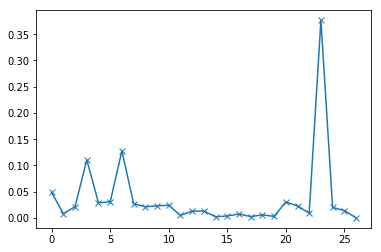

In [18]:
import matplotlib.pyplot as plt
plt.plot(cool_list[15][-2], marker='x')

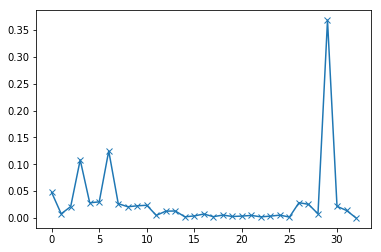

In [19]:
plt.plot(cool_list[19][-2], marker='x')

In [20]:
c1=cool_list[0][-1]
c2=cool_list[4][-1]
print(c1-c2)
np.all(c1==c2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


True

In [21]:
c1=np.array([-0.092, -0.177,  0.143,  0.121,  0.205,  0.279,  0.099, -0.022,
         0.131, -0.239,  0.165,  0.045,  0.377,  0.374, -0.327, -0.881,
         0.014, -0.072,  0.068,  0.853,  0.049, -0.008,  0.163, -0.104,
         0.09 ,  0.171,  0.025,  1.155,  0.053,  0.078,  0.424, -0.2  ,
         0.048, -0.357, -0.081, -0.18 ,  0.304, -0.246, -0.073, -0.072,
         0.446,  0.064, -0.101,  0.113,  0.197,  0.359, -0.276,  0.992,
        -0.32 ,  0.148, -0.253,  0.433, -0.089, -0.2  , -0.676,  0.002,
         0.513, -0.218, -0.391, -0.302, -0.155, -0.201, -0.811, -0.372])
c2=np.array([-0.171, -0.166,  0.08 ,  0.145,  0.241,  0.122,  0.062, -0.026,
         0.132, -0.256,  0.148,  0.032,  0.316,  0.42 , -0.426, -0.714,
        -0.016,  0.001,  0.067,  0.871,  0.049, -0.012, -0.004, -0.111,
         0.157,  0.304,  0.032,  0.655,  0.025,  0.112,  0.458, -0.166,
         0.106, -0.331, -0.027, -0.244,  0.215, -0.206, -0.018, -0.108,
         0.344,  0.057, -0.103,  0.067,  0.228,  0.187, -0.255,  1.037,
        -0.328,  0.216, -0.218,  0.347, -0.011, -0.209, -0.88 ,  0.   ,
         0.393, -0.152, -0.315, -0.324, -0.199, -0.004, -0.766, -0.278])

c1-c2

array([ 0.079, -0.011,  0.063, -0.024, -0.036,  0.157,  0.037,  0.004,
       -0.001,  0.017,  0.017,  0.013,  0.061, -0.046,  0.099, -0.167,
        0.03 , -0.073,  0.001, -0.018,  0.   ,  0.004,  0.167,  0.007,
       -0.067, -0.133, -0.007,  0.5  ,  0.028, -0.034, -0.034, -0.034,
       -0.058, -0.026, -0.054,  0.064,  0.089, -0.04 , -0.055,  0.036,
        0.102,  0.007,  0.002,  0.046, -0.031,  0.172, -0.021, -0.045,
        0.008, -0.068, -0.035,  0.086, -0.078,  0.009,  0.204,  0.002,
        0.12 , -0.066, -0.076,  0.022,  0.044, -0.197, -0.045, -0.094])

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=2)
X = pca.fit_transform([ting[1] for ting in cool_list])

In [24]:
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt

In [25]:
embed_dim = cool_list[0][1].shape[0]


In [26]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, Arrow, OpenHead

hover = HoverTool(tooltips=[("true action","@desc"), ("prediction", "@pred"),
                            ("not_skip_gate", "@not_skip")],names=['circle'])
p = figure( tools=[hover])

for i in range(1, len(X)):
    p.add_layout(Arrow(end=OpenHead(line_color="firebrick", size=10, line_width=2),
                       x_start=X[i-1,0], y_start=X[i-1,1],
                       x_end=X[i,0], y_end=X[i,1], line_color='gray'))

source = ColumnDataSource(data=dict(
    x=X[:,0],
    y=X[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][0] for ting in cool_list]
))
p.circle('x','y', source=source, size=10, name='circle')
# p.line(X[:,0], X[:,1])

X1 = pca.transform([ting[4] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X1[:,0],
    y=X1[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][0] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='green', name='circle')

X2 = pca.transform([ting[5] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X2[:,0],
    y=X2[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][0] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='red', name='circle')

x = pca.transform(np.zeros((1,embed_dim)))
p.circle(x[0,0], x[0,1], size=5, color='magenta')
p.circle(X[0,0], X[0,1], size=10, color='green')
p.circle(X[-1,0], X[-1,1], size=10, color='red')


GlyphRenderer(id='d9133188-5150-475d-b1c4-5cdffe4c4cd4', ...)

In [27]:
show(p)

In [38]:
print('utter_ask_price', '-->', domain.index_for_action('utter_ask_price'))
print('utter_ask_details', '-->', domain.index_for_action('utter_ask_details'))
print('utter_explain_details_hotel', '-->', domain.index_for_action('utter_explain_details_hotel'))
print('utter_explain_people_hotel', '-->', domain.index_for_action('utter_explain_people_hotel'))
print('utter_ask_location', '-->', domain.index_for_action('utter_ask_location'))
print('utter_explain_location_hotel', '-->', domain.index_for_action('utter_explain_location_hotel'))
print('utter_ask_startdate', '-->', domain.index_for_action('utter_ask_startdate'))
print('utter_suggest_hotel', '-->', domain.index_for_action('utter_suggest_hotel'))
print('action_search_hotel', '-->', domain.index_for_action('action_search_hotel'))
print('action_listen', '-->', domain.index_for_action('action_listen'))

utter_ask_price --> 5
utter_ask_details --> 27
utter_explain_details_hotel --> 13
utter_explain_people_hotel --> 18
utter_ask_location --> 4
utter_explain_location_hotel --> 16
utter_ask_startdate --> 6
utter_suggest_hotel --> 11
action_search_hotel --> 41
action_listen --> 0


In [ ]:
utter_price = embedding_from_tracker("#generate story\n{}".format(story_block), bot=True)[0,-1,5,:]
utter_price.shape

In [ ]:
print(utter_price.shape)
x = pca.transform(utter_price.reshape(1,-1))
p.circle(x[0][0], x[0][1], color='black')

In [ ]:
show(p)